## Controle Quântico Ótimo - Utilização do algoritmo de gradiente conjugado para ajuste do caminho percorrido por uma partícula

Nessa etapa, é necessário avaliar, a partir da equação de Schrödinger com os kets, com o método de Runge-Kutta e com o controle MPC, como a curva de origem ajusta-se a curva de destino. Além disso, é interessantíssimo a avaliação a partir do estado estacionário e ainda verificar como ocorre o ajuste de fases.

Para analisar como o controle melhora o condicionamento da curva através da sua análise futura, esse arquivo estará analisando os ajustes no horizonte 3 e 10. Para melhor coerência dos resultados, a otimização será utilizada para substituir na variável independente da função objetivo e ainda será normalizada para que as comparações tenham o mesmo peso.

Nesse projeto usa-se o gradiente devido a sua facilidade de reprodução, vide os projetos fora da biblioteca do python, além dos problemas do cálculo da Hessiana na otimização não linear utilizando o método de Newton e suas variantes.

Para uma aproximação ótima, utiliza-se um passo de integração (fator do Runge Kutta) com o valor de 0.01, prevendo um milésimo a frente, mas para uma aplicação real a intenção é o aumento dessa fator para uma produção mais real.

In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

import random

In [2]:
## CONSTANTES

# Considerações: constante de Planck verdadeira: 1, massa: 1

AMOSTRAGEM = 100 #(1/AMOSTRAGEM)
T = 10
PASSO = 0.01 # Para o passo do Runge-Kutta e para T
INICIO_ANALISE = 0.00 # Tempo inicial da analise em um horizonte
FINAL_ANALISE = 0.02 # Tempo final da analise em um horizonte
TAMANHO = 1000 # Tempo total de análise

ONDA_DESEJADA = [[complex((1/np.sqrt(2)),0.0)],[complex((-1/np.sqrt(2)),0.0)]] 

Abaixo se dão os requisitos básicos para a instauração do teste. Se tem formas de subtrair e somar matrizes, a manipulação das derivadas com o Runge-Kutta além da própria proposta da função objetivo.

In [3]:
# Manipulação das matrizes

def somar(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] + B[i][j]

    return C

def sub(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] - B[i][j]

    return C

In [4]:
## psi' = -i * H * ket{psi}
def dpsidt(t, psi, H): # A derivada da onda em relação ao tempo não tem dependência temporal
    A = np.zeros((2,2), dtype=np.complex_)
    A = np.dot(complex(0,1),H) # i * H
    return -1*np.matmul(A,psi) # - i * H * ket{psi}

# Runge-Kutta de quarta ordem

def rungeKutta(onda, fatorRungeKutta, hamiltoniano, tempoFinal = 2, tempoInicial = 0):
    
    resultado = np.zeros((2,2), dtype=np.complex_)
    indice = 0

    for i in range(0, 2):
        
        resultado[0][indice] = onda[0][0]
        resultado[1][indice] = onda[1][0]
        
        k1 = dpsidt(tempoInicial, onda, hamiltoniano)
        k2 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k1)), hamiltoniano)
        k3 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k2)), hamiltoniano)
        k4 = dpsidt(tempoInicial + fatorRungeKutta, somar(onda, np.dot(fatorRungeKutta, k3)), hamiltoniano)
        
        ## y(i+1) = y(i) + h/6*(k1+2*k2+2*k3+k4)
        
        A = somar(np.dot(2,k3), k4)
        B = somar(np.dot(2,k2), k1)
        C = somar(A, B)
 
        onda = somar(onda,np.dot((fatorRungeKutta / 6.0),(C)))
    
        tempoInicial += fatorRungeKutta
        
        indice += 1
        
    runge = np.zeros((2,1), dtype=np.complex_)
    runge[0][0] = resultado[0][indice-1]
    runge[1][0] = resultado[1][indice-1]
    return runge

def funcaoObjetivo(x, iteracao, ondaDesejada, hamiltoniano, ondaInicial, horizonteAnalisavel, fatorRungeKutta, tempoAnalise):
    
    avanco = np.zeros((2,1),dtype=np.complex_)
    
    y = 0
    
    horizonte = (horizonteAnalisavel+iteracao)/AMOSTRAGEM
    
    tempo = iteracao/AMOSTRAGEM    
    tempoInicialAnalise = INICIO_ANALISE
    tempoFinalAnalise = FINAL_ANALISE
    
    controles = np.zeros((2,2), dtype=np.complex_)
    controles = [[0, x[0]], [x[0], 0]]
    
    matrizInicial = np.zeros((2,1),dtype=np.complex_)
    matrizInicial = [[ondaInicial[0][0]], [ondaInicial[1][0]]] 

    matrizDesejada = np.zeros((2,1),dtype=np.complex_)
    
    ## Função-Objetivo (Return) = somatorio ||(Matriz_Origem - Matriz_Destino)||^2
    
    ## Avanço temporal
    
    matrizDesejada[0][0] = ondaDesejada[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
    matrizDesejada[1][0] = ondaDesejada[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)

    y += (np.linalg.norm(matrizInicial-matrizDesejada))**2

    avanco = rungeKutta(matrizInicial, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

    matrizInicial = avanco

    tempoInicialAnalise += PASSO
    tempoFinalAnalise += PASSO
    
    for indice in range((iteracao+1), (horizonteAnalisavel+iteracao)):
        tempo = indice/AMOSTRAGEM
        
        matrizDesejada[0][0] = ondaDesejada[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
        matrizDesejada[1][0] = ondaDesejada[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)
        
        y += (np.linalg.norm(matrizInicial-matrizDesejada))**2
        
        controles = [[0, x[int(tempoInicialAnalise*AMOSTRAGEM)]], [x[int(tempoInicialAnalise*AMOSTRAGEM)], 0]]

        avanco = rungeKutta(matrizInicial, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

        matrizInicial = avanco

        tempoInicialAnalise += PASSO
        tempoFinalAnalise += PASSO
    
    return y

Para o funcionamento do MPC, cria-se um looping que consiste em uma otimização não linear, com o apoio da biblioteca de otimização do pyhton, de forma a obter o melhor resultado para o ajuste da curva. Com esse valor em mãos, utiliza-se para os pontos da próxima iteração do método de controle além de efetivar o ajuste realizando o Runge-Kutta com o valor otimizado.

In [5]:
def main(horizonte, ondaInicial):
    
    it = 0
    
    u = [] # Chute inicial -> controladores
    u.append(random.uniform(-1, 1))
    for l in range(1, horizonte):
        u.append(u[0])
        
    # O que deve ser retornado
    minimos = np.zeros((1,TAMANHO), dtype=np.complex_) # Valores da otimização
    valoresFuncaoObjetivo = np.zeros((1,TAMANHO), dtype=np.complex_) # Comparação do valor encontrado com a FO
    constantes = np.zeros((2, TAMANHO), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
    valoresOnda = np.zeros((2, TAMANHO), dtype=np.complex_) # Guarda as variações da Onda Inicial
    
    hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    while it < TAMANHO:
        
        #print(f"Iteração: {iteracao+1}")
        
        # Variação do Psi
        valoresOnda[0][it] = ondaInicial[0][0]
        valoresOnda[1][it] = ondaInicial[1][0]

        # Obtenção das constantes que multiplicam Psi
        # C_0 = Psi_0/[e^(1/2*pi*tempo)] equação 2.18 Griffiths
        constantes[0][it] = ondaInicial[0][0]/np.exp(-1*complex(0,1)*(1/2*np.pi)*it/AMOSTRAGEM)
        constantes[1][it] = ondaInicial[1][0]/np.exp(-1*complex(0,1)*(3/2*np.pi)*it/AMOSTRAGEM)
        
        ## Minimização
    
        resultado = optimize.minimize(funcaoObjetivo, u, args=(it, ONDA_DESEJADA, hamiltoniano, ondaInicial, horizonte, PASSO, TAMANHO), method='CG')

        # Função objetivo

        minimos[0][it] = resultado.x[0]

        valoresFuncaoObjetivo[0][it] = funcaoObjetivo(resultado.x, it, ONDA_DESEJADA, hamiltoniano, ondaInicial, horizonte, PASSO, TAMANHO)

        ## Hamiltoniano corntrolado

        controle = np.zeros((2,1), dtype=np.complex_)
        controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
        hamiltoniano = somar(hamiltoniano, controle)

        ## Adaptação da onda ao controle

        ondaAvancada = np.zeros((2,2), dtype=np.complex_)
        ondaAvancada = rungeKutta(ondaInicial, PASSO, hamiltoniano, tempoFinal = FINAL_ANALISE, tempoInicial = INICIO_ANALISE)

        ondaInicial[0][0] = ondaAvancada[0][0]
        ondaInicial[1][0] = ondaAvancada[1][0]

        # Reset
        hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

        u = []
        for l in range(0, horizonte):
            u.append(resultado.x[0])
        
        it += 1
        
    return minimos, valoresFuncaoObjetivo, constantes, valoresOnda

### Avaliação das componentes

Um grande problemas dos métodos de minimização está concentrado no cálculo numérico. O cálculo númerico se trata de um processo de aproximação de forma que quanto pior é a manipulação das variáveis, pior ficará a aproximação. Nesse sistema se torna perceptível a melhoria do ajuste através da desafagem de uma curva em relação a outra.

Conforme o livro, introdução à computação clássica e quântica de Thomas Wong (2022), a defasagem apresentada por um sistema quântico não tem significado físico se for a mesma para todo o sistema, ou seja, todas as componentes devem ter a mesma diferença de fases. Para realizar essa avaliação, se faz necessário propor uma diferença entre a curva original e o destino, tanto na primeira componente quanto na segunda, além de realizar a diferença entre essas partes.

In [6]:
def evolucaoDesejada():
    evolucaoDesejada = np.zeros((2,TAMANHO), dtype=np.complex_)
    for i in range(0, TAMANHO):
        evolucaoDesejada[0][i] = ((1/np.sqrt(2))*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/AMOSTRAGEM))
        evolucaoDesejada[1][i] = ((-1/np.sqrt(2))*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/AMOSTRAGEM))
        
    return evolucaoDesejada

In [7]:
def evolucaoPrimeiraComponente(valoresOnda, evolucaoDesejada):
    ts = np.linspace(0, T, TAMANHO)

    realInicialPrimeiraComponente = [elemento.real for elemento in valoresOnda[0]] 
    imaginarioInicialPrimeiraComponente = [elemento.imag for elemento in valoresOnda[0]] 

    realDesejadoPrimeiraComponente = [elemento.real for elemento in evolucaoDesejada[0]] 
    imaginarioDesejadoPrimeiraComponente = [elemento.imag for elemento in evolucaoDesejada[0]] 

    # Plotagem
    plt.subplot(2,1,1)

    plt.ylabel('Real') 
    plt.xlabel('Tempo') 
    plt.title('Primeira componente -> real')
    plt.plot(ts, realInicialPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Inicial")
    plt.plot(ts, realDesejadoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Desejado")
    plt.legend(loc='upper right')

    plt.subplot(2,1,2)

    plt.ylabel('Imaginário') 
    plt.xlabel('Tempo') 
    plt.title('Primeira componente -> imaginária')
    plt.plot(ts, imaginarioInicialPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Inicial")
    plt.plot(ts, imaginarioDesejadoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Desejado")
    plt.legend(loc='upper right')

    plt.tight_layout()

In [8]:
def evolucaoSegundaComponente(valoresOnda, evolucaoDesejada):
    ts = np.linspace(0, T, TAMANHO)

    realInicialSegundaComponente = [elemento.real for elemento in valoresOnda[1]] 
    imaginarioInicialSegundaComponente = [elemento.imag for elemento in valoresOnda[1]] 

    realDesejadoSegundaComponente = [elemento.real for elemento in evolucaoDesejada[1]] 
    imaginarioDesejadoSegundaComponente = [elemento.imag for elemento in evolucaoDesejada[1]] 

    # Plotagem
    plt.subplot(2,1,1)

    plt.ylabel('Real') 
    plt.xlabel('Tempo') 
    plt.title('Segunda componente -> real')
    plt.plot(ts, realInicialSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Inicial")
    plt.plot(ts, realDesejadoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Desejado")
    plt.legend(loc='upper right')

    plt.subplot(2,1,2)

    plt.ylabel('Imaginário') 
    plt.xlabel('Tempo') 
    plt.title('Segunda componente -> imaginária')
    plt.plot(ts, imaginarioInicialSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Inicial")
    plt.plot(ts, imaginarioDesejadoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Desejado")
    plt.legend(loc='upper right')

    plt.tight_layout()

### Variação dos horizontes

Como será observado a frente, a variação dos horizontes auxiliam na melhoria da defasagem apresentada pelo sistema, no entanto isso gera complicações no custo computacional.

In [9]:
desejo = evolucaoDesejada()

ondaInicial = [[complex(0.0,0.0)],[complex(1.0,0.0)]] 
minimos, valoresFuncaoObjetivo, constantes, valoresOnda = main(3, ondaInicial)

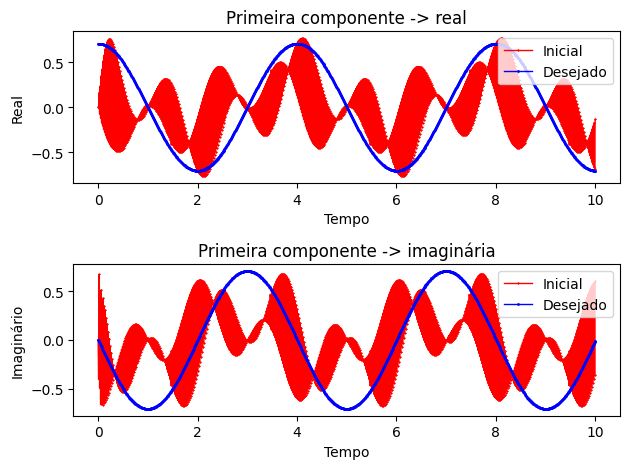

In [10]:
evolucaoPrimeiraComponente(valoresOnda, desejo)

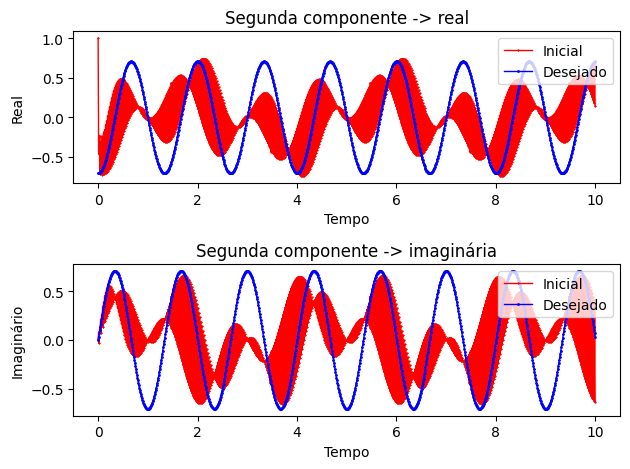

In [11]:
evolucaoSegundaComponente(valoresOnda, desejo)

In [12]:

ondaInicial = [[complex(0.0,0.0)],[complex(1.0,0.0)]]
minimos, valoresFuncaoObjetivo, constantes, valoresOnda = main(30, ondaInicial)

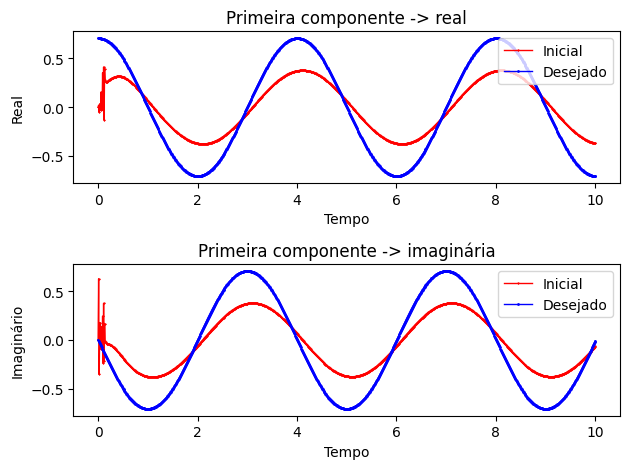

In [13]:
evolucaoPrimeiraComponente(valoresOnda, desejo)

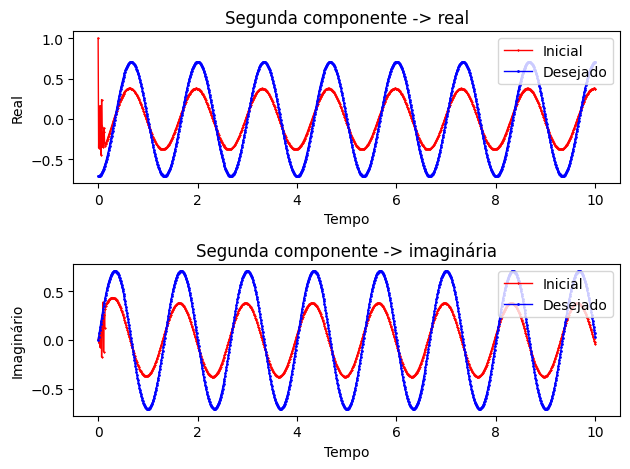

In [14]:
evolucaoSegundaComponente(valoresOnda, desejo)